In [141]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### 读取数据

In [142]:
x_s=pd.read_excel(io='Molecular_Descriptor.xlsx')
print(x_s.shape)
x_s.head()

(1974, 730)


SMILES  nAcid   ALogP    ALogp2  \
0  Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCC3)c4ccc(OCCN5C...      0 -0.2860  0.081796   
1  Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCCCC3)c4ccc(OCCN...      0 -0.8620  0.743044   
2  Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN...      0  0.7296  0.532316   
3  Oc1ccc2O[C@H]([C@@H](CC3CCCCC3)Sc2c1)c4ccc(OCC...      0 -0.3184  0.101379   
4  Oc1ccc2O[C@H]([C@@H](Cc3ccccc3)Sc2c1)c4ccc(OCC...      0  1.3551  1.836296   

        AMR       apol  naAromAtom  nAromBond  nAtom  nHeavyAtom  ...  \
0  126.1188  74.170169          12         12     64          31  ...   
1  131.9420  80.357341          12         12     70          33  ...   
2  139.9304  74.064997          18         18     62          33  ...   
3  133.4822  80.357341          12         12     70          33  ...   
4  143.1903  76.356583          18         18     64          33  ...   

           MW     WTPT-1    WTPT-2     WTPT-3     WTPT-4    WTPT-5  WPATH  \
0  439.218115  64.771680  2.089409  15.471445   8.858910  3.406628   3011   
1  467.249415  68.960024  2.089698  15.486947   8.863774  3.406648   3516   
2  463.181729  68.748923  2.083301  18.011114  11.390412  3.406644   3542   
3  467.249415  68.883696  2.087385  15.468365   8.857943  3.406624   3594   
4  461.202465  68.883696  2.087385  15.468365   8.857943  3.406624   3594   

   WPOL  XLogP  Zagreb  
0    47  4.666     166  
1    54  5.804     174  
2    52  2.964     176  
3    50  6.015     174  
4    50  4.462     174  

[5 rows x 730 columns]

In [143]:
y_s=pd.read_excel(io='ERα_activity.xlsx')
y_s.head()

SMILES  IC50_nM     pIC50
0  Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCC3)c4ccc(OCCN5C...      2.5  8.602060
1  Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCCCC3)c4ccc(OCCN...      7.5  8.124939
2  Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN...      3.1  8.508638
3  Oc1ccc2O[C@H]([C@@H](CC3CCCCC3)Sc2c1)c4ccc(OCC...      3.9  8.408935
4  Oc1ccc2O[C@H]([C@@H](Cc3ccccc3)Sc2c1)c4ccc(OCC...      7.4  8.130768

In [144]:
#复制原数据
x=copy.deepcopy(x_s).iloc[:,1:]
y=copy.deepcopy(y_s).iloc[:,-1]
print(x.shape,y.shape)

(1974, 729) (1974,)


### 观察各特征与PIC50的对应关系

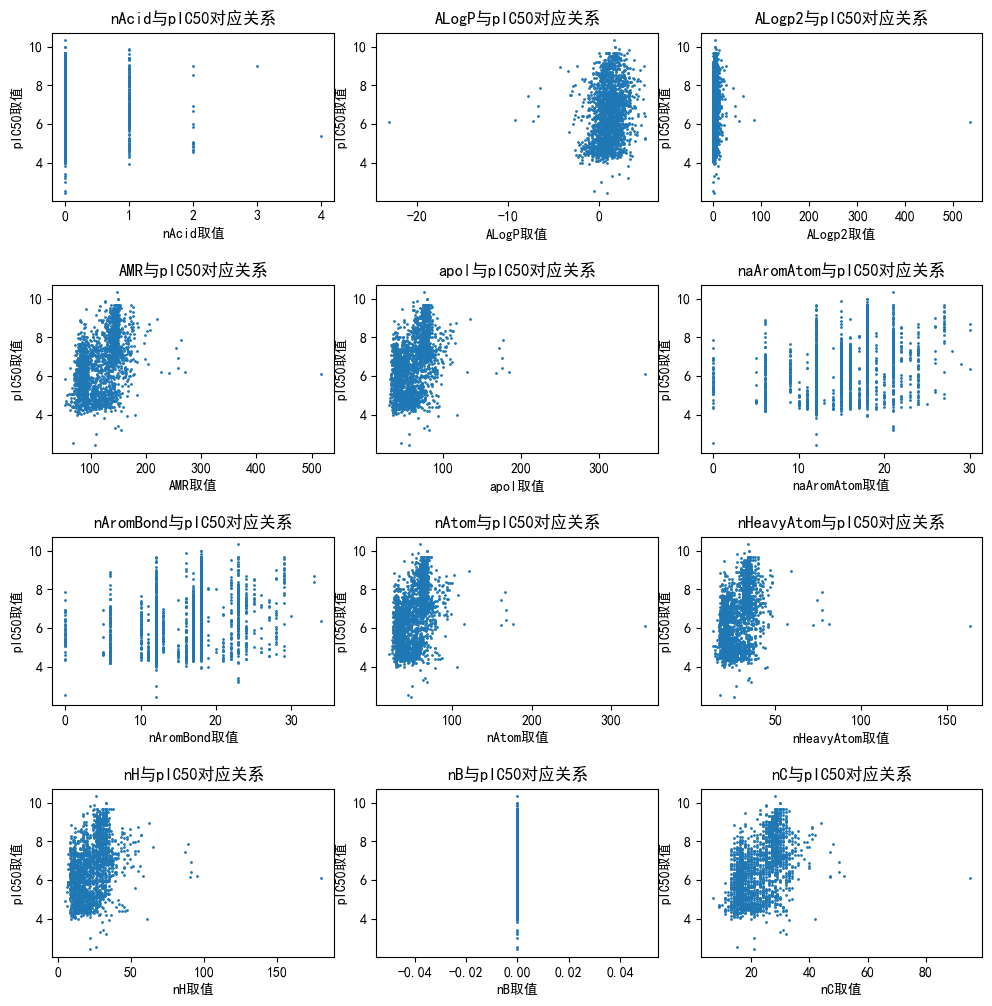

In [145]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.5)
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.scatter(x.iloc[:,i],y,s=1)
    plt.ylabel("pIC50取值")
    plt.xlabel(list(x)[i]+"取值")
    plt.title(list(x)[i]+"与pIC50对应关系")

### 去除低方差

In [146]:
import sklearn.feature_selection as fs


s_model=fs.VarianceThreshold(threshold=0.02)
s_model.fit(x)
x=s_model.transform(x)
variance=s_model.variances_#返回所有数据的方差


filtr_variance=[]#过滤出需要的高方差
#画一下图
label=[]
for i in range(x.shape[1]):
    for key in x_s:
        a=np.array(x[:,i])
        b=np.array(x_s[key])
        if(np.array_equal(a,b)):
            label.append(key)
            index=x_s.columns.get_loc(key)-1
            filtr_variance.append(variance[index])


##### 过滤前的方差

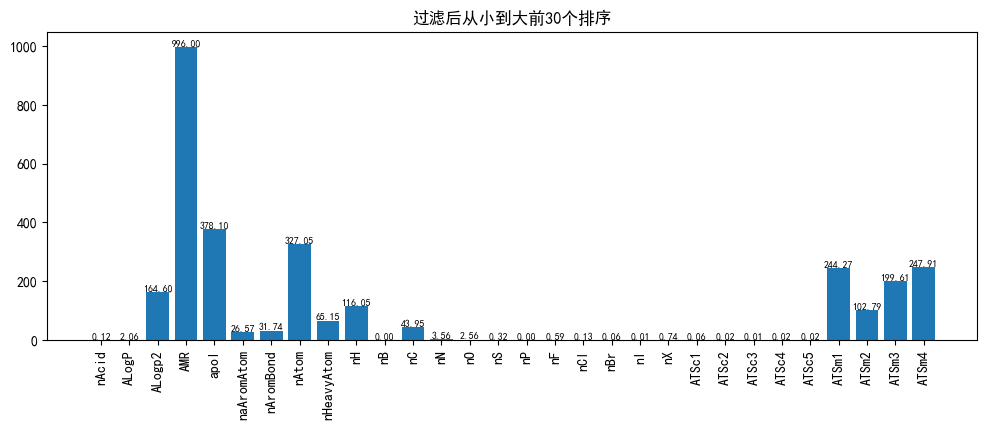

In [160]:
plt.figure(figsize=(12,4))
plt.bar(list(x_s)[1:31],variance[:30])
plt.xticks(rotation=90)
plt.title("过滤后从小到大前30个排序")
for a,b in zip(list(x_s)[1:31],variance[:30]):   #柱子上的数字显示
    plt.text(a,b,'%.2f'%b,ha='center',va='bottom',fontsize=7)
plt.show()

##### 过滤后的方差

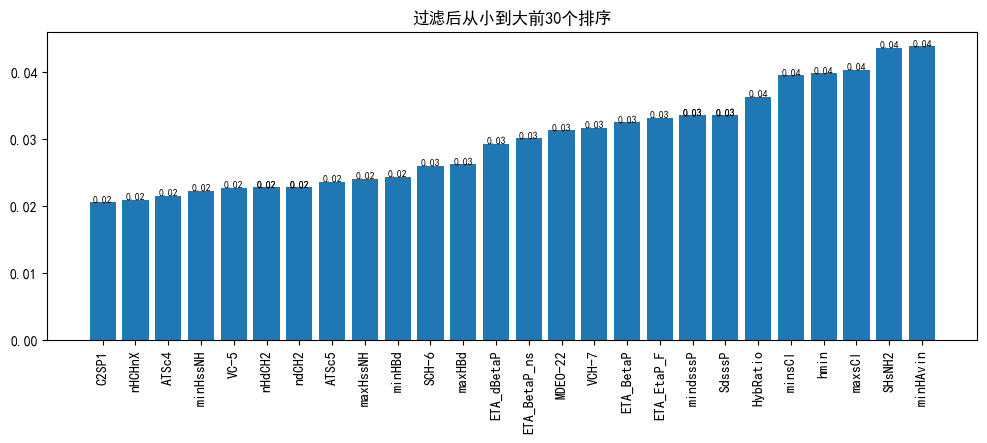

In [147]:

filter_image=pd.DataFrame([filtr_variance],columns=label)

filter_image.sort_values(by=0,inplace=True,axis=1)

plt.figure(figsize=(12,4))
plt.bar(filter_image.columns.values[:30],filter_image.iloc[0,:30])
plt.xticks(rotation=90)
plt.title("过滤后从小到大前30个排序")
for a,b in zip(filter_image.columns.values[:30],filter_image.iloc[0,:30]):   #柱子上的数字显示
    plt.text(a,b,'%.2f'%b,ha='center',va='bottom',fontsize=7)
plt.show()

### 使用随机森林进行特征选择

In [148]:
from sklearn import tree
onethree=tree.DecisionTreeRegressor()
onethree=onethree.fit(x,y)
feature_important=onethree.feature_importances_
feature_important.shape

(393,)

In [149]:
#获取最重要的前三十个的数组
##排序返回从小到大的下标
feature_important_index=feature_important.argsort()
x_thrity=x[:,feature_important_index[-30:]]
pd.DataFrame(x_thrity).head()

0         1          2         3    4         5         6         7   \
0  5.26590  0.460175  13.254859  0.000000  0.0  6.050188  9.019729  5.245435   
1  5.26590  0.460175  13.617609  0.000000  0.0  6.083246  9.255431  5.256770   
2  7.46270  0.519350  13.393453  3.358891  0.0  6.020424  9.760737  4.910140   
3  5.26590  0.460206  13.079547  0.000000  0.0  6.071897  8.706054  5.239956   
4  7.24809  0.462912  13.043454  0.000000  0.0  6.046045  8.706054  5.238827   

          8    9   ...        20        21     22        23        24     25  \
0  58.060335  0.0  ...  0.469126  0.000000  2.288 -1.331303  0.269680  67.23   
1  60.060335  0.0  ...  0.449126  0.000000  2.288 -1.378628  0.269680  67.23   
2  60.392427  1.0  ...  0.516534  9.842059  2.901 -1.608354  0.495846  87.46   
3  57.728243  0.0  ...  0.456486  0.000000  2.288 -1.350874  0.269680  67.23   
4  57.728243  0.0  ...  0.473631  0.000000  2.603 -1.449689  0.269680  67.23   

         26   27         28         29  
0  6.593009  0.0   9.968948  28.277932  
1  6.674642  0.0  10.058948  31.076748  
2  6.502751  0.0   9.752886  30.901064  
3  6.622142  0.0  10.025028  30.570001  
4  6.552810  0.0   9.993342  30.570001  

[5 rows x 30 columns]

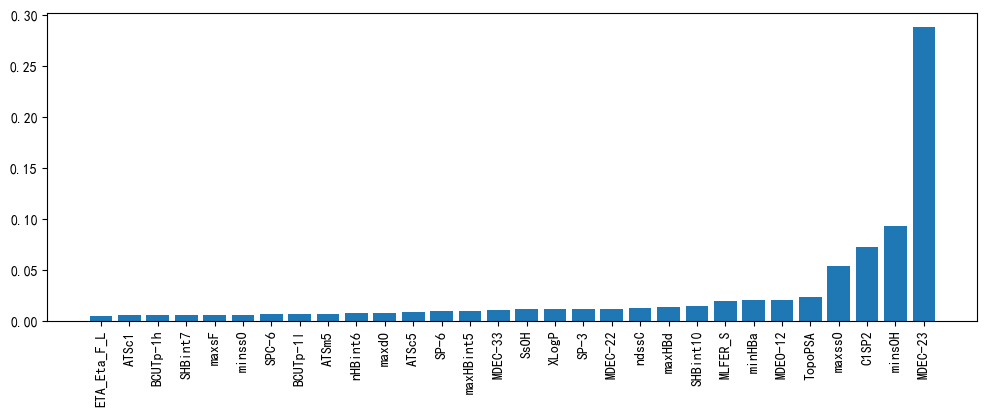

In [150]:
#找到这30列是对应的哪些化合物
label_thrity=[]
for i in range(x_thrity.shape[1]):
    for key in x_s:
        a=np.array(x_thrity[:,i])
        b=np.array(x_s[key])
        if(np.array_equal(a,b)):
            label_thrity.append(key)
plt.figure(figsize=(12,4))
plt.bar(label_thrity,feature_important[feature_important_index][-30:])
plt.xticks(rotation=90)
plt.show()

### 使用皮埃尔相关系数计算30个特征加一个plC50

In [151]:
piaier=x_s[label_thrity]
label_thrity.append('plC50')
piaier=np.concatenate((np.array(piaier),y[:,np.newaxis]),axis=1)
piaier=pd.DataFrame(piaier,columns=label_thrity).corr()
display(piaier)

C:\TempFiles\ipykernel_2624\3909936530.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  piaier=np.concatenate((np.array(piaier),y[:,np.newaxis]),axis=1)


ETA_Eta_F_L     ATSc1  BCUTp-1h   SHBint7     maxsF    minssO  \
ETA_Eta_F_L     1.000000  0.647203  0.177794  0.326064  0.132836  0.386184   
ATSc1           0.647203  1.000000  0.012359  0.503462  0.128231  0.415396   
BCUTp-1h        0.177794  0.012359  1.000000 -0.007238 -0.036211  0.158641   
SHBint7         0.326064  0.503462 -0.007238  1.000000  0.017629  0.012085   
maxsF           0.132836  0.128231 -0.036211  0.017629  1.000000 -0.083998   
minssO          0.386184  0.415396  0.158641  0.012085 -0.083998  1.000000   
SPC-6           0.299503  0.352800  0.563207  0.249970  0.113430  0.115797   
BCUTp-1l       -0.307110 -0.321846  0.002100 -0.113916 -0.535462 -0.078978   
ATSm5           0.600251  0.666368  0.539892  0.414950  0.068529  0.308179   
nHBint6         0.288365  0.555792  0.000081  0.585432 -0.025679 -0.035601   
maxdO           0.154167  0.339607  0.023820  0.233749 -0.050736 -0.014303   
ATSc5          -0.167462 -0.329849 -0.062911 -0.253912  0.085653  0.009726   
SP-6            0.613632  0.489623  0.569709  0.231497  0.040260  0.373596   
maxHBint5       0.064784  0.237013 -0.190518  0.201269 -0.005719  0.089322   
MDEC-33         0.416109  0.303588  0.198891  0.112638  0.104343  0.396701   
SsOH            0.033568 -0.115522  0.044135  0.163063  0.010329  0.061505   
XLogP          -0.004110 -0.229834  0.414321 -0.228979  0.031864  0.110249   
SP-3            0.729608  0.640245  0.515145  0.331950  0.014781  0.406173   
MDEC-22         0.363005  0.092421  0.478503 -0.043741  0.008350  0.238352   
ndssC           0.268697  0.567340  0.110954  0.401599 -0.020721  0.028882   
maxHBd          0.066090 -0.076531 -0.117789  0.165953  0.198883 -0.096709   
SHBint10        0.267590  0.285952 -0.012286  0.394851  0.129511  0.015844   
MLFER_S         0.767349  0.783139  0.087827  0.530254 -0.051551  0.239572   
minHBa         -0.407965 -0.363237 -0.241495 -0.138583  0.066812 -0.275126   
MDEO-12         0.316416  0.513172 -0.132485  0.145077 -0.054659  0.577766   
TopoPSA         0.468542  0.733023  0.003224  0.621186 -0.091275  0.071144   
maxssO          0.404613  0.439980  0.166788  0.015402 -0.076407  0.996300   
C1SP2           0.252362  0.556743 -0.201395  0.332885  0.007948 -0.118580   
minsOH         -0.008999 -0.203842  0.149855  0.038747  0.039273  0.132199   
MDEC-23         0.599652  0.191638  0.525435 -0.001039  0.059669  0.384934   
plC50           0.253043 -0.028127  0.428526  0.020627  0.112420  0.211172   

                SPC-6  BCUTp-1l     ATSm5   nHBint6  ...  SHBint10   MLFER_S  \
ETA_Eta_F_L  0.299503 -0.307110  0.600251  0.288365  ...  0.267590  0.767349   
ATSc1        0.352800 -0.321846  0.666368  0.555792  ...  0.285952  0.783139   
BCUTp-1h     0.563207  0.002100  0.539892  0.000081  ... -0.012286  0.087827   
SHBint7      0.249970 -0.113916  0.414950  0.585432  ...  0.394851  0.530254   
maxsF        0.113430 -0.535462  0.068529 -0.025679  ...  0.129511 -0.051551   
minssO       0.115797 -0.078978  0.308179 -0.035601  ...  0.015844  0.239572   
SPC-6        1.000000 -0.082276  0.675041  0.214483  ...  0.195373  0.319370   
BCUTp-1l    -0.082276  1.000000 -0.147625 -0.089686  ... -0.196732 -0.127055   
ATSm5        0.675041 -0.147625  1.000000  0.467893  ...  0.301109  0.663261   
nHBint6      0.214483 -0.089686  0.467893  1.000000  ...  0.390646  0.629191   
maxdO        0.235804 -0.159959  0.247920  0.136835  ... -0.113942  0.276933   
ATSc5       -0.073695 -0.043258 -0.282481 -0.552485  ... -0.172713 -0.409379   
SP-6         0.806504 -0.109632  0.728965  0.179621  ...  0.215674  0.522827   
maxHBint5    0.005260 -0.020919  0.070864  0.198460  ...  0.195387  0.212225   
MDEC-33      0.521743 -0.099964  0.420421 -0.085212  ...  0.110271  0.254261   
SsOH         0.130573 -0.198239  0.013350  0.006334  ...  0.422241 -0.062459   
XLogP        0.180145 -0.020240  0.149312 -0.154622  ... -0.043458 -0.203933   
SP-3         0.706108 -0.124420  0.807930  0.357215  ...  0.284778  0.698908

In [152]:
plt.figure(figsize=(20,20),dpi=600)
sns.heatmap(piaier,annot=True,vmax=1,square=True,cmap="Blues_r")
plt.show()

然后从这30个分子挑选出与plC50相关性强，但与其他分子相关性弱的分析

In [153]:
sort_correlation=piaier['plC50'].abs().sort_values(ascending=False)

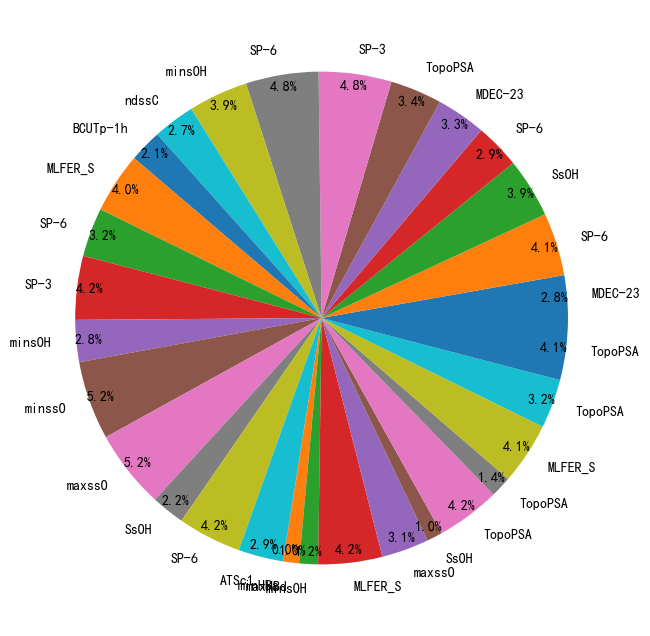

In [154]:
#最终筛选出分子
max_molecule=[]
for key,value in sort_correlation.iteritems():
    maxKey=''
    maxValue=0
    for i,j in piaier[key].iteritems():
        if i!=key:
            if maxValue<j:
                maxKey=i
                maxValue=j
    max_molecule.append([maxKey,maxValue])
max_molecule=pd.DataFrame(max_molecule)
# print(max_molecule.shape)
plt.figure(figsize=(8,8))
plt.pie(max_molecule.iloc[:,1],labels=max_molecule.iloc[:,0],autopct="%.1f%%",pctdistance=0.95)
plt.show()
# print(sort_correlation)

In [155]:
twinty_molecule=[
    'MDEC-23',
    'minsOH',
    'BCUTp-1h',
    'C1SP2',
    'maxdO',
    'XLogP',
    'ATSm5',
    'maxHBd',
    'maxssO',
    'SHBint10',
    'SPC-6',
    'BCUTp-1l',
    'maxsF',
    'minHBa',
    'MDEO-12',
    'ATSc5',
    'maxHBint5',
    'ATSc1',
    'gmin',
    'SHBint7'
]

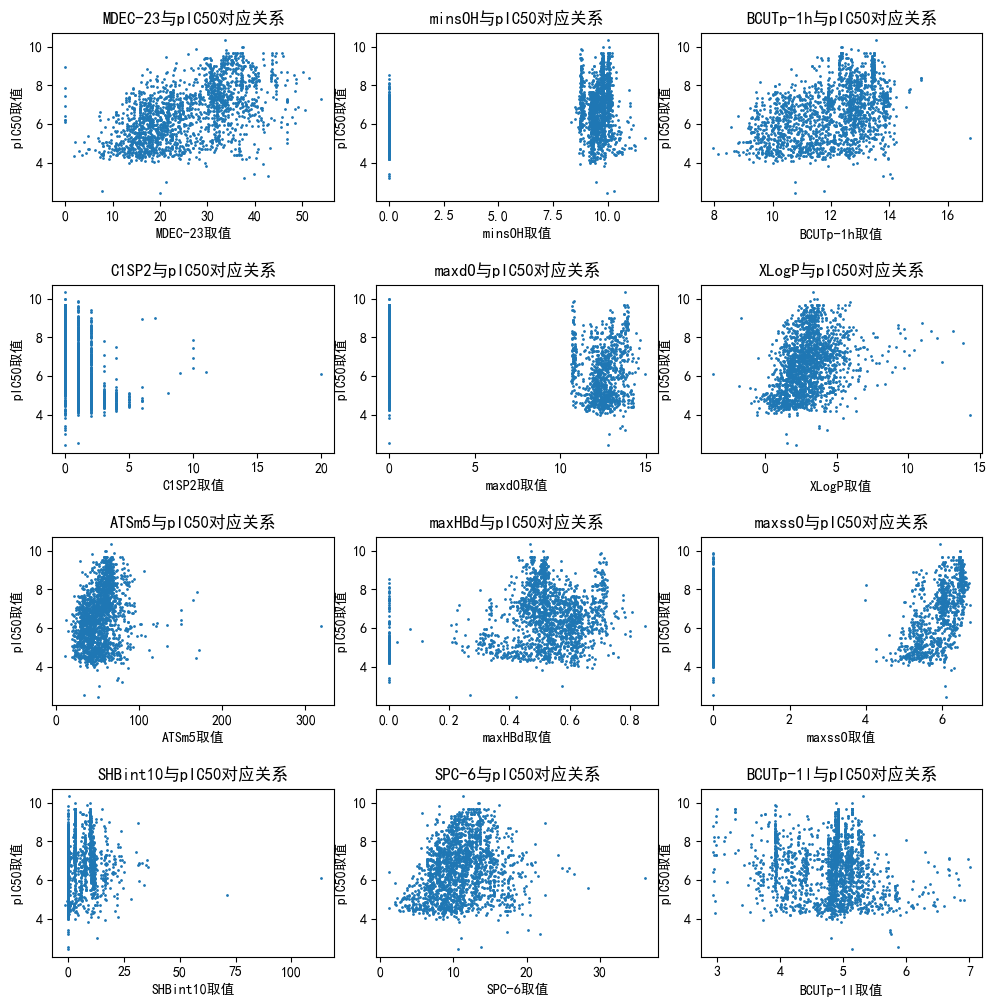

In [156]:
x=x_s[twinty_molecule]
plt.figure(figsize=(12,12))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.5)
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.scatter(x.iloc[:,i],y,s=1)
    plt.ylabel("pIC50取值")
    plt.xlabel(list(x)[i]+"取值")
    plt.title(list(x)[i]+"与pIC50对应关系")

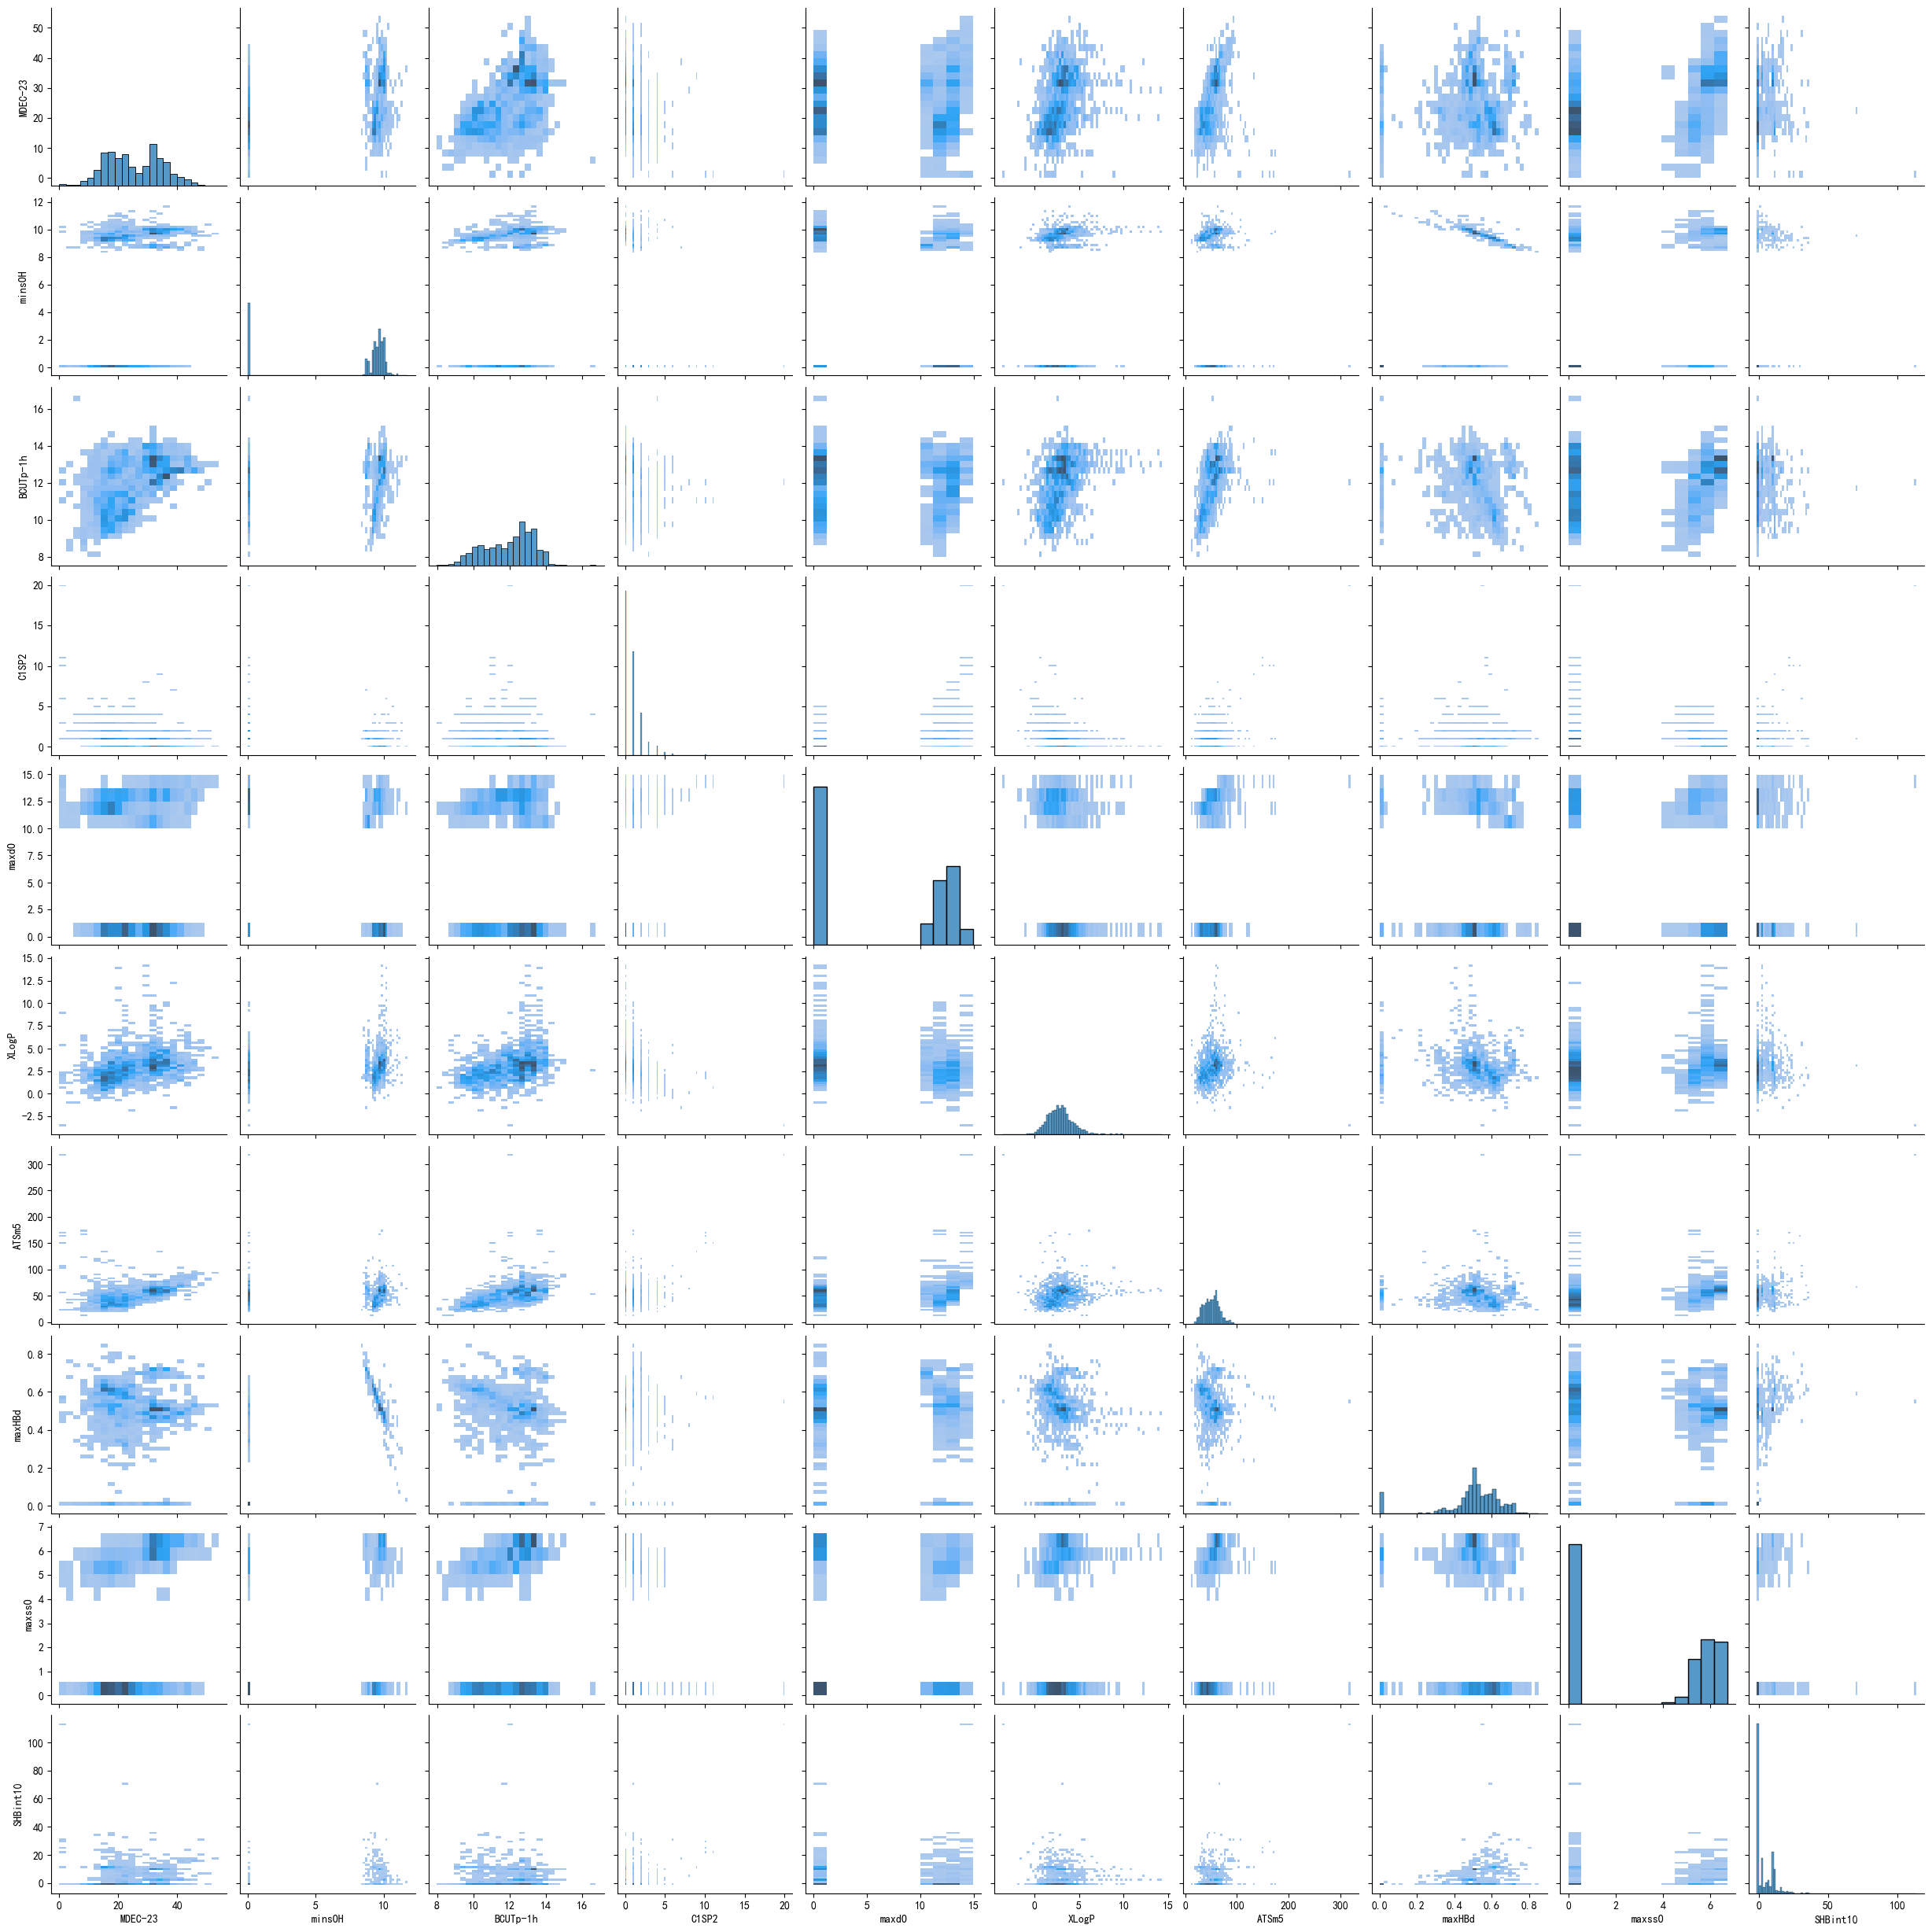

In [157]:
sns.pairplot(data=x[twinty_molecule].iloc[:,:10], kind="hist")